VISTO LEZ 13

In [1]:
#remember to clone https://github.com/brcondor/Architectures_for_Big_Data into '/home/jovyan/work/'
import sys
sys.path.append("/home/jovyan/work/Architectures_for_Big_Data/")
import pyspark
sc = pyspark.SparkContext("local[3]")

In [2]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *
from datetime import datetime

dataset = datasetGenerator()
dataset.addGenerator(idGenerator(),prefix="book",min=1,max=100,keyName="bookId")
dataset.addGenerator(idGenerator(),prefix="token",min=1,max=5000,keyName="tokenId")

bookTokens = sc.parallelize( dataset.generateDataset(250000)).persist()
bookTokens.first()

{'bookId': 'book_0085', 'tokenId': 'token_04952'}

# Black Belt Histogram (= how a professional would build it)

In [3]:
## Compute the term frequency for each token w.r.t. each book
bookTermFrequency = bookTokens.map(lambda x: ((x.get("bookId"),x.get("tokenId")),1)).reduceByKey(lambda x,y: x+y)\
                    .map(lambda x: {"bookId":x[0][0],"tokenId":x[0][1], "termFrequency":x[1]} ).persist()
bookTermFrequency.count()

196671

In [6]:
bookTermFrequency.take(5)

[{'bookId': 'book_0044', 'tokenId': 'token_04756', 'termFrequency': 1},
 {'bookId': 'book_0053', 'tokenId': 'token_02191', 'termFrequency': 1},
 {'bookId': 'book_0077', 'tokenId': 'token_02646', 'termFrequency': 2},
 {'bookId': 'book_0080', 'tokenId': 'token_04884', 'termFrequency': 2},
 {'bookId': 'book_0038', 'tokenId': 'token_02960', 'termFrequency': 1}]

In [13]:
## Compute the hist for token frequencies
btfRes = bookTermFrequency.map(lambda x: (x.get("termFrequency"),1)).reduceByKey(lambda x,y: x+y)
btfRes.top(15,key=lambda x: x[1])
# as you can see, most of them appear only once, which is reasonable cuz of sparse dataset

[(1, 151564), (2, 37868), (3, 6346), (4, 810), (5, 77), (6, 5), (7, 1)]

<BarContainer object of 7 artists>

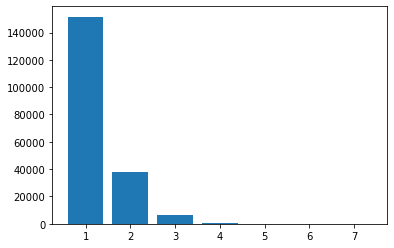

In [12]:
import matplotlib.pyplot as plt

plt.bar(btfRes.map(lambda x: x[0]).collect(), btfRes.map(lambda x: x[1]).collect())

# TF-IDF 
## Reading from a CDC Master table

In [5]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *
from datetime import datetime

dataset = datasetGenerator()
dataset.addGenerator(idGenerator(),prefix="book",min=1,max=100,keyName="bookId")
dataset.addGenerator(idGenerator(),prefix="token",min=1,max=500,keyName="tokenId")
dataset.addGenerator(intGenerator(),min=1,max=1000,keyName="termFrequency")
dataset.addGenerator(dateGenerator(),startdate=datetime(2018,1,1),max=datetime(2020,1,1),keyName="insertDate")


bookTermFrequencyUniform = sc.parallelize( dataset.generateDataset(250000)).persist()
bookTermFrequencyUniform.first()

{'bookId': 'book_0002',
 'tokenId': 'token_0295',
 'termFrequency': 699,
 'insertDate': datetime.datetime(2017, 6, 1, 10, 25, 31)}

In [7]:
## add exponentiality ==> np.random.exponential()
import numpy as np
def exp(row):
    row["termFrequency"] = int(np.random.exponential() * row["termFrequency"])
    return row
bookTermFrequency = bookTermFrequencyUniform.map(lambda x: exp(x))
bookTermFrequency.first()

{'bookId': 'book_0002',
 'tokenId': 'token_0295',
 'termFrequency': 900,
 'insertDate': datetime.datetime(2017, 6, 1, 10, 25, 31)}

### Extract Master Data Snapshot

In [4]:
## lets get the snapshot of bookTermFrequency (is a Master Data Registry)
def getKeys(row):
    return row["bookId"], row["tokenId"]
def getTs(row):
    pass
    
bookTermFrequencySnapshot_step0 = bookTermFrequency.map(
bookTermFrequencySnapshot_step0.first()

(('book_0024', 'token_0386'),
 (datetime.datetime(2013, 7, 1, 4, 45, 10),
  {'bookId': 'book_0024',
   'tokenId': 'token_0386',
   'termFrequency': 2618,
   'insertDate': datetime.datetime(2013, 7, 1, 4, 45, 10)}))

In [9]:

def getKeys(row):
    return row["bookId"], row["tokenId"]
def getTs(row):
    return row["insertDate"]
    
bookTermFrequencySnapshot_step0 = bookTermFrequency.map(lambda x: (getKeys(x), (getTs(x),x)))
bookTermFrequencySnapshot_step0.first()

(('book_0002', 'token_0295'),
 (datetime.datetime(2017, 6, 1, 10, 25, 31),
  {'bookId': 'book_0002',
   'tokenId': 'token_0295',
   'termFrequency': 900,
   'insertDate': datetime.datetime(2017, 6, 1, 10, 25, 31)}))

In [10]:
# take only the last value
bookTermFrequencySnapshot_step1 = bookTermFrequencySnapshot_step0.reduceByKey(lambda x,y: x if x[0]>y[0] else y)
bookTermFrequencySnapshot_step1.first()

(('book_0002', 'token_0295'),
 (datetime.datetime(2019, 4, 10, 13, 58, 29),
  {'bookId': 'book_0002',
   'tokenId': 'token_0295',
   'termFrequency': 6,
   'insertDate': datetime.datetime(2019, 4, 10, 13, 58, 29)}))

In [11]:
# come back to the dict per row format
bookTermFrequencySnapshot = bookTermFrequencySnapshot_step1.map(lambda x: x[1][1])
bookTermFrequencySnapshot.count()

49644

In [12]:
bookTermFrequencySnapshot.first()

{'bookId': 'book_0002',
 'tokenId': 'token_0295',
 'termFrequency': 6,
 'insertDate': datetime.datetime(2019, 4, 10, 13, 58, 29)}

## inverseDocumentFrequency (iDF)

In [14]:
## compute iDF - start with distribution of tokens
iDF = bookTermFrequencySnapshot.map(lambda x: (x.get("tokenId"),1)).reduceByKey(lambda x,y: x+y)
iDF.take(5)

[('token_0295', 100),
 ('token_0446', 99),
 ('token_0261', 98),
 ('token_0500', 100),
 ('token_0365', 100)]

In [8]:
iDF.take(5)
# iDF(term1) = log(N_tot/N_with_term1)...

[('token_0419', 100),
 ('token_0259', 100),
 ('token_0046', 100),
 ('token_0278', 99),
 ('token_0176', 100)]

In [18]:
# compute iDF (again)
import numpy as np
totBooks = bookTermFrequencySnapshot.map(lambda x: x.get("bookId")).distinct().count() 
iDF = bookTermFrequencySnapshot.map(lambda x: (x.get("tokenId"),1)).reduceByKey(lambda x,y: x+y)\
                .map(lambda x: (x[0],np.log(x[1]/totBooks)))
iDF.take(5)

[('token_0295', 0.0),
 ('token_0446', -0.01005033585350145),
 ('token_0261', -0.020202707317519466),
 ('token_0500', 0.0),
 ('token_0365', 0.0)]

# Exercise (1) - solo and small teams
The actual dataset generator always generate data from a random distribution.

e.g., id generator returns 
```python
return prefix+"_"+str(randint(min, max)).zfill(len(str(max))+1)
```

If we would like to use it in these exercises, we would need to create stronger id generator where the sampling strategy could be changed. Provide an implementation of 
```python
class nonUniformeIdGenerator(typeGenerator)
class expIntGenerator(typeGenerator)
class expFloatGenerator(typeGenerator)
```

# Exercise (2) - additional (mandatory for Big Team)
Extend datasetGenerator() 
```python
class logDataset(datasetGenerator)
class registryDataset(typeGenerator)
class cdcRegistryDataset(typeGenerator)
```

In [23]:
## combine bookTermFrequency with iDF to obtain 
## {'bookId': 'book_0097', 'tokenId': 'token_0359', 'termFrequency': 576,"iDF":0.12, "TF-iDF":576*0.12}
def parser(x):
    x[1][0]["iDF"] = x[1][1]
    x[1][0]["TF-iDF"] = x[1][1]*x[1][0].get("termFrequency")
    return x[1][0]

bookTFiDF = bookTermFrequency.map(lambda x: (x.get("tokenId"),x)).join(iDF).map(lambda x: parser(x))
bookTFiDF.first()

{'bookId': 'book_0002',
 'tokenId': 'token_0295',
 'termFrequency': 55,
 'insertDate': datetime.datetime(2017, 6, 1, 10, 25, 31),
 'iDF': 0.0,
 'TF-iDF': 0.0}

In [24]:
bookTFiDF.map(lambda x: x.get("TF-iDF")).stats()

(count: 250000, mean: -3.586772870725633, stdev: 8.19504185972357, max: 0.0, min: -218.3710633950679)

# Book Similarity

In [14]:
bookTFiDF.first()

{'bookId': 'book_0024',
 'tokenId': 'token_0386',
 'termFrequency': 2618,
 'insertDate': datetime.datetime(2013, 7, 1, 4, 45, 10),
 'iDF': 1.0,
 'TF-iDF': 2618.0}

```python
sim(bookA,bookB) = sum(bookA_token_i * bookB_token_i)/(norm(bookA)*norm(bookA))
```

In [15]:
bookA_bookB_contributions = bookTFiDF.map(lambda x: (x.get("tokenId"),x)).join(bookTFiDF.map(lambda x: (x.get("tokenId"),x)))
bookA_bookB_contributions.first()

('token_0386',
 ({'bookId': 'book_0024',
   'tokenId': 'token_0386',
   'termFrequency': 2618,
   'insertDate': datetime.datetime(2013, 7, 1, 4, 45, 10),
   'iDF': 1.0,
   'TF-iDF': 2618.0},
  {'bookId': 'book_0024',
   'tokenId': 'token_0386',
   'termFrequency': 2618,
   'insertDate': datetime.datetime(2013, 7, 1, 4, 45, 10),
   'iDF': 1.0,
   'TF-iDF': 2618.0}))

In [16]:
# lets make a triangular matrix
bookA_bookB_contrTriang = bookA_bookB_contributions.filter(lambda x: (x[1][0].get("bookId")>x[1][1].get("bookId")))
bookA_bookB_contrTriang.first()

('token_0386',
 ({'bookId': 'book_0024',
   'tokenId': 'token_0386',
   'termFrequency': 2618,
   'insertDate': datetime.datetime(2013, 7, 1, 4, 45, 10),
   'iDF': 1.0,
   'TF-iDF': 2618.0},
  {'bookId': 'book_0013',
   'tokenId': 'token_0386',
   'termFrequency': 15,
   'insertDate': datetime.datetime(2015, 6, 13, 8, 50, 25),
   'iDF': 1.0,
   'TF-iDF': 15.0}))

In [17]:
# now we need to build the line to apply the sum 
eachTokenContr = bookA_bookB_contrTriang.map(lambda x: (x[1]))\
                                        .map(lambda x: ((x[0].get("bookId"),x[1].get("bookId")),x[0].get("TF-iDF")*x[1].get("TF-iDF")))
eachTokenContr.first()

(('book_0024', 'book_0013'), 39270.0)

In [18]:
bookToBookSimilarity = eachTokenContr.reduceByKey(lambda x,y: x+y)
bookToBookSimilarity.take(5)

[(('book_0024', 'book_0008'), 3242869498.8676004),
 (('book_0042', 'book_0005'), 3206962047.1919),
 (('book_0042', 'book_0018'), 3025013447.9978995),
 (('book_0042', 'book_0041'), 3022717698.029099),
 (('book_0074', 'book_0025'), 3538634467.577501)]

In [21]:
#extract for each book to 5 closer books
bookToBookSimilarity.map(lambda x: (x[0][0],[(x[1],x[0][1])])).reduceByKey(lambda x,y: sorted(x+y,reverse=True)[0:5]).take(5)

[('book_0053',
  [(3590301567.3896003, 'book_0052'),
   (3489360515.0072994, 'book_0040'),
   (3466590605.894301, 'book_0051'),
   (3460133157.069299, 'book_0016'),
   (3366735828.3003, 'book_0015')]),
 ('book_0018',
  [(3192012053.4111996, 'book_0015'),
   (3144117112.1008997, 'book_0009'),
   (3112992650.2337, 'book_0001'),
   (3109398537.7997, 'book_0002'),
   (3084158099.4837003, 'book_0016')]),
 ('book_0071',
  [(3454754921.7724, 'book_0025'),
   (3442670399.305601, 'book_0064'),
   (3391127566.771599, 'book_0070'),
   (3384377553.7736998, 'book_0040'),
   (3342645726.244, 'book_0066')]),
 ('book_0026',
  [(3323608755.313201, 'book_0003'),
   (3275116812.9099007, 'book_0008'),
   (3258084699.6224, 'book_0025'),
   (3246206971.6847005, 'book_0015'),
   (3221652920.2483997, 'book_0016')]),
 ('book_0062',
  [(3309376624.3505006, 'book_0052'),
   (3174253797.3231006, 'book_0014'),
   (3173889914.4335, 'book_0025'),
   (3094063962.836199, 'book_0054'),
   (3092812587.9716997, 'book_001

# Exercise 2
In the previous example, we computed only the book_A_i*book_B_i... we missed the part below...